In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import nltk
nltk.download('punkt')  # For word_tokenize
nltk.download('stopwords')  # For stopwords
nltk.download('wordnet')  # For WordNetLemmatizer

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1006)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1006)>
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('data_text/cleaned_reviews.csv', encoding="ISO-8859-1")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,love the led lights connects quickly the recha...,16,1.0
1,neutral,the keyboard itself as keyboard works fine how...,177,4.0
2,positive,the scrolling wheel is not working properly af...,28,5.0
3,neutral,long battery life due to sleep mode was impres...,19,5.0
4,neutral,my bf loves his new headphone the cord is kind...,16,5.0


In [4]:
df.count()

sentiments               17340
cleaned_review           17337
cleaned_review_length    17340
review_score             17340
dtype: int64

In [5]:
df.isnull().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [8]:
type_counts = df.sentiments.value_counts(dropna=False)
type_counts

sentiments
positive    9503
neutral     6300
negative    1534
Name: count, dtype: int64

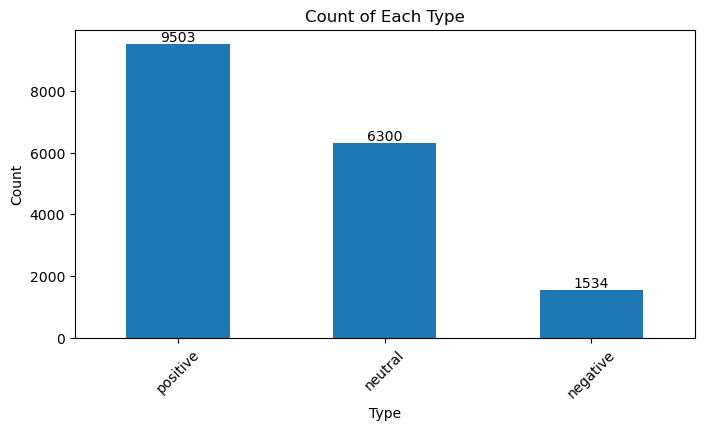

In [9]:
plt.figure(figsize=(8, 4))
bars = type_counts.plot(kind='bar')
plt.title('Count of Each Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

for index, value in enumerate(type_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

In [10]:
ps = PorterStemmer() 

def preprocessing(sentence, lemma=True, stemming=True, tokenize=True, stopword=True):

    sentence = str(sentence).lower()
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', ' ', sentence)
    sentence = re.sub(' +', ' ', sentence)

    if tokenize:
        words = word_tokenize(sentence)
    else:
        words = sentence.split()

    if stopword:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    if stemming:
        words = [ps.stem(word) for word in words]

    if lemma:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words), words

In [11]:
df['processed_text'] = ""
df['words_list'] = None

In [14]:
for i, row in df.iterrows():
    processed_sentence, words_list = preprocessing(row['cleaned_review'])
    df.at[i, 'processed_text'] = processed_sentence
    df.at[i, 'words_list'] = words_list

In [15]:
df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score,processed_text,words_list
0,positive,love the led lights connects quickly the recha...,16,1.0,love led light connect quickli recharg featur ...,"[love, led, light, connect, quickli, recharg, ..."
1,neutral,the keyboard itself as keyboard works fine how...,177,4.0,keyboard keyboard work fine howev thing need i...,"[keyboard, keyboard, work, fine, howev, thing,..."
2,positive,the scrolling wheel is not working properly af...,28,5.0,scroll wheel work properli month buy new mous ...,"[scroll, wheel, work, properli, month, buy, ne..."
3,neutral,long battery life due to sleep mode was impres...,19,5.0,long batteri life due sleep mode impress scrol...,"[long, batteri, life, due, sleep, mode, impres..."
4,neutral,my bf loves his new headphone the cord is kind...,16,5.0,bf love new headphon cord kind long complain,"[bf, love, new, headphon, cord, kind, long, co..."


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df.sentiments, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [18]:
X_val[:3], y_val[:3]

(11599                               would nice actual work
 6480              work cheap great mous mean also like mad
 7378     order silver receiv black worth time return bi...
 Name: processed_text, dtype: object,
 11599     neutral
 6480     positive
 7378     negative
 Name: sentiments, dtype: object)

## CountVectorizer with N_Grams

In [19]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vect, y_train)

y_val_pred = model.predict(X_val_vect)
val_accuracy = accuracy_score(y_val, y_val_pred)
f1_micro = f1_score(y_val, y_val_pred, average='micro')
f1_macro = f1_score(y_val, y_val_pred, average='macro')

y_val_proba = model.predict_proba(X_val_vect)
auroc = roc_auc_score(y_val, y_val_proba, multi_class='ovr')

In [20]:
predicted_categories_examples = model.predict(X_val_vect[:3])

actual_categories_examples = y_val[:3].values

for actual, predicted in zip(actual_categories_examples, predicted_categories_examples):
    print(f"Actual: {actual} - Predicted: {predicted}")

Actual: neutral - Predicted: neutral
Actual: positive - Predicted: positive
Actual: negative - Predicted: neutral


In [21]:
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score (Micro)', 'F1 Score (Macro)', 'AUROC'],
    'n_grams': [val_accuracy, f1_micro, f1_macro, auroc]
})

results_df

,Metric,n_grams
0,Accuracy,0.847729
1,F1 Score (Micro),0.847729
2,F1 Score (Macro),0.770088
3,AUROC,0.931400
